# Multi-Class Cardiac Segmentation with DINOv3 on ACDC

This notebook adapts the foreground segmentation approach to perform **4-class cardiac segmentation** (Background, Right Ventricle, Myocardium, Left Ventricle) on the ACDC cardiac MRI dataset using DINOv3 patch features + multinomial logistic regression.

The ACDC data has been preprocessed by `cinema.data.acdc.preprocess`:
- Labels unified to {0=BG, 1=RV, 2=MYO, 3=LV}
- Resampled to 1×1×10 mm spacing
- Center-cropped to 192×192
- Intensity normalized, cast to uint8 [0–255]

### Imports and Constants

In [1]:
import os
import pickle
from pathlib import Path

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as T
from cinema.segmentation.dataset import EndDiastoleEndSystoleDataset
from monai.transforms import ScaleIntensityd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from tqdm import tqdm

/Users/lbokeria/projects/health_gc/heartfm-evals/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ── Paths ──
ACDC_DATA_DIR = Path("/Users/lbokeria/projects/health_gc/data/heartfm/processed/acdc")
REPO_DIR = "../models/dinov3/"
WEIGHTS_PATH = "../model_weights/dinov3_vitb16.pth"

# ── Scale ──
N_TRAIN_PATIENTS = 5
N_TEST_PATIENTS = 3

# ── Model / patch constants ──
PATCH_SIZE = 16
IMAGE_SIZE = 192  # native ACDC crop size, divisible by 16 → 12×12 patch grid
MODEL_NAME = "dinov3_vitb16"
MODEL_TO_NUM_LAYERS = {
    "dinov3_vitb16": 12,
    "dinov3_vits16": 12,
    "dinov3_vitl16": 24,
}
N_LAYERS = MODEL_TO_NUM_LAYERS[MODEL_NAME]

# ── ImageNet normalization (DINOv3 pretrained with this) ──
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

# ── Class definitions ──
CLASS_NAMES = {0: "BG", 1: "RV", 2: "MYO", 3: "LV"}
NUM_CLASSES = len(CLASS_NAMES)

# ── Visualization colours (RGBA) ──
CLASS_COLORS = {
    0: (0, 0, 0, 0),        # BG — transparent
    1: (0, 0, 1, 0.4),      # RV — blue
    2: (0, 1, 0, 0.4),      # Myo — green
    3: (1, 0, 0, 0.4),      # LV — red
}

### Load DINOv3 Model

In [3]:
model = torch.hub.load(REPO_DIR, MODEL_NAME, source="local", weights=WEIGHTS_PATH)
model.eval()
print(f"Loaded {MODEL_NAME} with {sum(p.numel() for p in model.parameters()):,} parameters")

Loaded dinov3_vitb16 with 85,669,632 parameters


### Load ACDC Data

We use `EndDiastoleEndSystoleDataset` from the CineMA package. Each sample provides an ED or ES
3-D volume `(1, 192, 192, z)` plus the corresponding label volume. We apply `ScaleIntensityd` to
rescale uint8 images to [0, 1].

In [4]:
train_meta_df = pd.read_csv(ACDC_DATA_DIR / "train_metadata.csv").head(N_TRAIN_PATIENTS)
test_meta_df = pd.read_csv(ACDC_DATA_DIR / "test_metadata.csv").head(N_TEST_PATIENTS)

transform = ScaleIntensityd(keys="sax_image", factor=1 / 255, channel_wise=False)

train_dataset = EndDiastoleEndSystoleDataset(
    data_dir=ACDC_DATA_DIR / "train",
    meta_df=train_meta_df,
    views="sax",
    transform=transform,
)

test_dataset = EndDiastoleEndSystoleDataset(
    data_dir=ACDC_DATA_DIR / "test",
    meta_df=test_meta_df,
    views="sax",
    transform=transform,
)

print(f"Train dataset: {len(train_dataset)} samples ({N_TRAIN_PATIENTS} patients × 2 frames)")
print(f"Test  dataset: {len(test_dataset)} samples ({N_TEST_PATIENTS} patients × 2 frames)")

Train dataset: 10 samples (5 patients × 2 frames)
Test  dataset: 6 samples (3 patients × 2 frames)


### Helper Functions

1. **`preprocess_slice`** — repeat single-channel slice to 3 channels + ImageNet normalize.
2. **`majority_vote_patch_labels`** — quantize a label slice to a 12×12 patch grid via majority vote.
3. **`dice_score`** — per-class Dice coefficient.
4. **`overlay_labels`** — create an RGBA colour overlay from a label map.

In [5]:
imagenet_normalize = T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)


def preprocess_slice(image_2d: torch.Tensor) -> torch.Tensor:
    """Prepare a (192, 192) [0,1] tensor for DINOv3.

    Returns a (1, 3, 192, 192) batch tensor.
    """
    # (192, 192) -> (1, 192, 192) -> (3, 192, 192)
    x = image_2d.unsqueeze(0).repeat(3, 1, 1)
    x = imagenet_normalize(x)
    return x.unsqueeze(0)  # add batch dim


def majority_vote_patch_labels(
    label_2d: torch.Tensor,
    patch_size: int = PATCH_SIZE,
    purity_threshold: float = 0.5,
) -> torch.Tensor:
    """Quantize a (H, W) label map to patch-level labels via majority vote.

    Patches where the dominant class covers < `purity_threshold` of pixels are
    assigned label -1 (to be filtered out later).

    Returns a 1-D tensor of length n_patches.
    """
    label_2d_long = label_2d.long()
    patches = label_2d_long.unfold(0, patch_size, patch_size).unfold(1, patch_size, patch_size)
    # patches shape: (h_patches, w_patches, patch_size, patch_size)
    patches = patches.reshape(-1, patch_size * patch_size)  # (n_patches, pixels_per_patch)
    patch_labels = torch.mode(patches, dim=1).values        # (n_patches,)

    if purity_threshold > 0:
        # compute fraction of majority class per patch
        counts = torch.zeros(patches.shape[0], NUM_CLASSES, dtype=torch.long)
        for c in range(NUM_CLASSES):
            counts[:, c] = (patches == c).sum(dim=1)
        max_counts = counts.max(dim=1).values
        purity = max_counts.float() / (patch_size * patch_size)
        patch_labels[purity < purity_threshold] = -1

    return patch_labels


def dice_score(
    pred: np.ndarray, true: np.ndarray, class_idx: int
) -> float:
    """Compute Dice coefficient for a single class."""
    pred_c = pred == class_idx
    true_c = true == class_idx
    intersection = (pred_c & true_c).sum()
    return float(2 * intersection / (pred_c.sum() + true_c.sum() + 1e-8))


def overlay_labels(
    label_map: np.ndarray,
    h: int,
    w: int,
    class_colors: dict | None = None,
) -> np.ndarray:
    """Create an RGBA overlay image from a label map of shape (h, w)."""
    if class_colors is None:
        class_colors = CLASS_COLORS
    overlay = np.zeros((h, w, 4), dtype=np.float32)
    for cls, rgba in class_colors.items():
        mask = label_map == cls
        for ch in range(4):
            overlay[:, :, ch][mask] = rgba[ch]
    return overlay

### Visualize a Sample Slice

Let’s look at a single training slice and its label overlay.

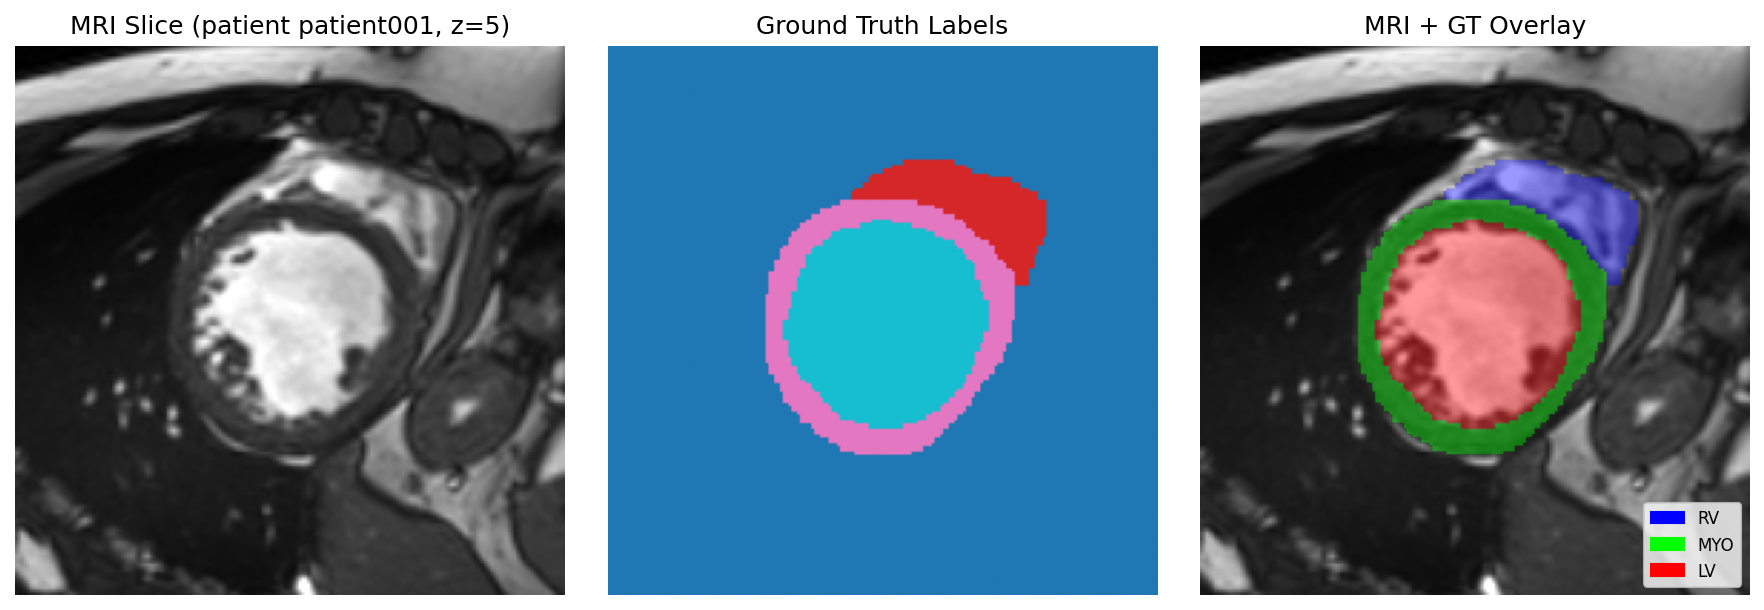

In [6]:
sample = train_dataset[0]
image_3d = sample["sax_image"]  # (1, 192, 192, z)
label_3d = sample["sax_label"]  # (1, 192, 192, z)
n_slices = sample["n_slices"]
pid = sample["pid"]

# pick a mid-slice
z_mid = n_slices // 2
image_2d = image_3d[0, :, :, z_mid].numpy()
label_2d = label_3d[0, :, :, z_mid].numpy().astype(int)

h_patches = IMAGE_SIZE // PATCH_SIZE
w_patches = IMAGE_SIZE // PATCH_SIZE
label_overlay = overlay_labels(label_2d, IMAGE_SIZE, IMAGE_SIZE)

fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=150)
axes[0].imshow(image_2d, cmap="gray")
axes[0].set_title(f"MRI Slice (patient {pid}, z={z_mid})")
axes[0].axis("off")

axes[1].imshow(label_2d, cmap="tab10", vmin=0, vmax=3)
axes[1].set_title("Ground Truth Labels")
axes[1].axis("off")

axes[2].imshow(image_2d, cmap="gray")
axes[2].imshow(label_overlay)
axes[2].set_title("MRI + GT Overlay")
axes[2].axis("off")

# legend
legend_patches = [
    mpatches.Patch(color=CLASS_COLORS[c][:3] + (1.0,), label=CLASS_NAMES[c])
    for c in range(1, NUM_CLASSES)
]
axes[2].legend(handles=legend_patches, loc="lower right", fontsize=8)
plt.tight_layout()
plt.show()

### Patch Quantization Visualization

Visualize the majority-vote patch labels on the 12×12 grid.

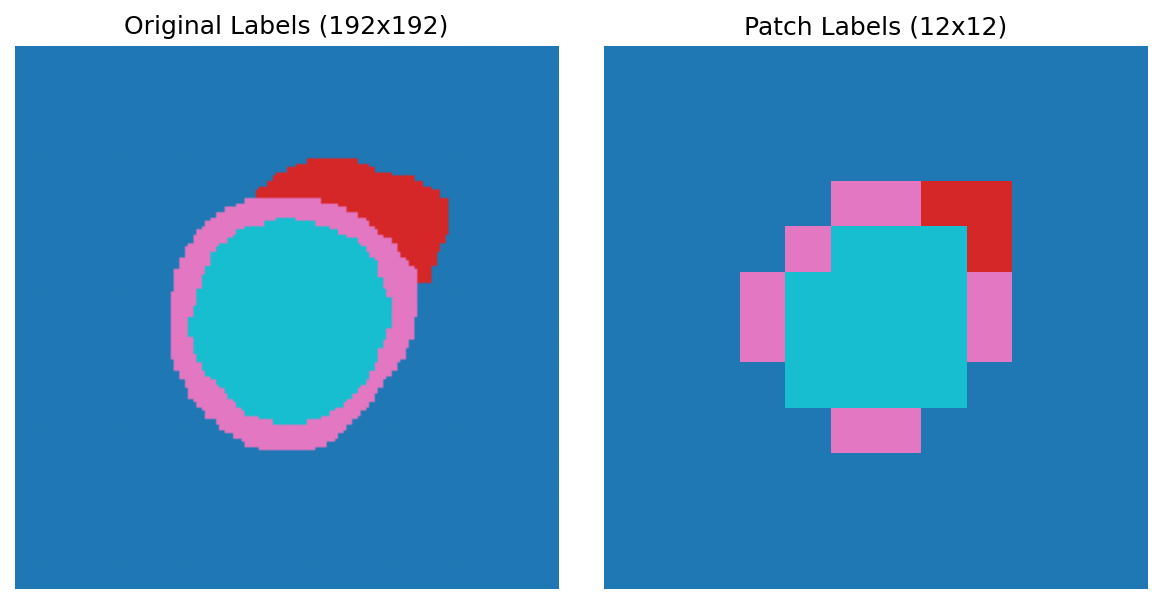

In [7]:
label_2d_tensor = label_3d[0, :, :, z_mid]
patch_labels_vis = majority_vote_patch_labels(label_2d_tensor, purity_threshold=0.0)
patch_grid = patch_labels_vis.reshape(h_patches, w_patches).numpy()

fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
axes[0].imshow(label_2d, cmap="tab10", vmin=0, vmax=3)
axes[0].set_title(f"Original Labels ({IMAGE_SIZE}x{IMAGE_SIZE})")
axes[0].axis("off")

axes[1].imshow(patch_grid, cmap="tab10", vmin=0, vmax=3)
axes[1].set_title(f"Patch Labels ({h_patches}x{w_patches})")
axes[1].axis("off")

plt.tight_layout()
plt.show()

### Feature Extraction (Training Set)

Loop over all training samples, extract 2-D slices along the z-axis, preprocess, run through DINOv3,
and collect:
- `xs`: patch feature vectors (n_patches, dim)
- `ys`: patch labels (n_patches,)
- `patient_index`: which patient each patch belongs to (for leave-one-out CV)

In [8]:
xs_list: list[torch.Tensor] = []
ys_list: list[torch.Tensor] = []
patient_index_list: list[torch.Tensor] = []

# build a mapping from dataset index -> patient index (for CV)
# dataset has 2 entries per patient (ED + ES)
pid_list_train: list[str] = []

with torch.inference_mode():
    for sample_idx in tqdm(range(len(train_dataset)), desc="Train samples"):
        sample = train_dataset[sample_idx]
        image_3d = sample["sax_image"]  # (1, 192, 192, z)
        label_3d = sample["sax_label"]  # (1, 192, 192, z)
        n_slices = sample["n_slices"]
        pid = sample["pid"]

        # patient index: same for ED and ES of same patient
        if pid not in pid_list_train:
            pid_list_train.append(pid)
        pat_idx = pid_list_train.index(pid)

        for z in range(n_slices):
            image_2d = image_3d[0, :, :, z]  # (192, 192)
            label_2d = label_3d[0, :, :, z]  # (192, 192)

            # patch labels via majority vote
            patch_labels = majority_vote_patch_labels(label_2d, purity_threshold=0.5)

            # preprocess for DINOv3
            img_input = preprocess_slice(image_2d)  # (1, 3, 192, 192)

            # extract features
            feats = model.get_intermediate_layers(
                img_input, n=range(N_LAYERS), reshape=True, norm=True
            )
            dim = feats[-1].shape[1]
            patch_feats = (
                feats[-1].squeeze().view(dim, -1).permute(1, 0).detach().cpu()
            )  # (n_patches, dim)

            xs_list.append(patch_feats)
            ys_list.append(patch_labels)
            patient_index_list.append(
                torch.full((patch_labels.shape[0],), pat_idx, dtype=torch.long)
            )

# concatenate
xs_all = torch.cat(xs_list)
ys_all = torch.cat(ys_list)
patient_index_all = torch.cat(patient_index_list)

# filter out impure patches (label == -1)
valid_mask = ys_all >= 0
xs = xs_all[valid_mask]
ys = ys_all[valid_mask]
patient_index = patient_index_all[valid_mask]

print(f"Feature matrix shape : {xs.shape}")
print(f"Label vector shape   : {ys.shape}")
print(f"Unique patients      : {len(pid_list_train)}")
print(f"Filtered out {(~valid_mask).sum().item()} impure patches")
print(f"Label distribution   : {dict(zip(*np.unique(ys.numpy(), return_counts=True)))}")

Train samples: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]

Feature matrix shape : torch.Size([14271, 768])
Label vector shape   : torch.Size([14271])
Unique patients      : 5
Filtered out 129 impure patches
Label distribution   : {np.int64(0): np.int64(12283), np.int64(1): np.int64(394), np.int64(2): np.int64(647), np.int64(3): np.int64(947)}


## Training

### Patient-Level Leave-One-Out CV for C Selection

We search over 8 values of C (1e-7 to 1e0) using **patient-level leave-one-out cross-validation**.
For each fold, all slices from one patient are held out as validation. The metric is
**macro-averaged Dice** (excluding background).

In [10]:
cs = np.logspace(-7, 0, 8)
n_patients_train = len(pid_list_train)
scores = np.zeros((n_patients_train, len(cs)))  # macro Dice per fold x C

xs_np = xs.numpy()
ys_np = ys.numpy().astype(int)
patient_index_np = patient_index.numpy()

for i in range(n_patients_train):
    print(f"\nValidation fold: patient {pid_list_train[i]}")
    train_sel = patient_index_np != i
    val_sel = patient_index_np == i

    fold_x_train = xs_np[train_sel]
    fold_y_train = ys_np[train_sel]
    fold_x_val = xs_np[val_sel]
    fold_y_val = ys_np[val_sel]

    for j, c in enumerate(cs):
        print(f"  C={c:.2e}", end=" ")
        clf = LogisticRegression(
            random_state=0,
            C=c,
            solver="lbfgs",
            max_iter=1000,
        ).fit(fold_x_train, fold_y_train)

        preds = clf.predict(fold_x_val)

        # macro Dice excluding background (classes 1, 2, 3)
        class_dices = [
            dice_score(preds, fold_y_val, c_idx) for c_idx in range(1, NUM_CLASSES)
        ]
        macro_dice = np.mean(class_dices)
        scores[i, j] = macro_dice
        print(f"macro Dice={macro_dice:.3f}")

print("\n--- CV complete ---")


Validation fold: patient patient001
  C=1.00e-07 macro Dice=0.000
  C=1.00e-06 macro Dice=0.000
  C=1.00e-05 macro Dice=0.000
  C=1.00e-04 macro Dice=0.000
  C=1.00e-03 macro Dice=0.447
  C=1.00e-02 macro Dice=0.751
  C=1.00e-01 macro Dice=0.808
  C=1.00e+00 macro Dice=0.759

Validation fold: patient patient002
  C=1.00e-07 macro Dice=0.000
  C=1.00e-06 macro Dice=0.000
  C=1.00e-05 macro Dice=0.000
  C=1.00e-04 macro Dice=0.000
  C=1.00e-03 macro Dice=0.516
  C=1.00e-02 macro Dice=0.782
  C=1.00e-01 macro Dice=0.805
  C=1.00e+00 macro Dice=0.767

Validation fold: patient patient003
  C=1.00e-07 macro Dice=0.000
  C=1.00e-06 macro Dice=0.000
  C=1.00e-05 macro Dice=0.000
  C=1.00e-04 macro Dice=0.000
  C=1.00e-03 macro Dice=0.453
  C=1.00e-02 macro Dice=0.818
  C=1.00e-01 macro Dice=0.873
  C=1.00e+00 macro Dice=0.848

Validation fold: patient patient004
  C=1.00e-07 macro Dice=0.000
  C=1.00e-06 macro Dice=0.000
  C=1.00e-05 macro Dice=0.000
  C=1.00e-04 macro Dice=0.000
  C=1.00e-03

### Choosing the Best C

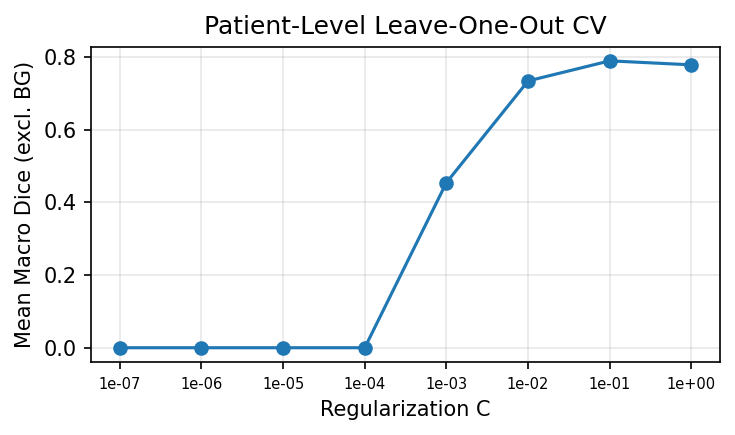

Best C = 1.00e-01 (mean macro Dice = 0.7900)


In [11]:
mean_scores = scores.mean(axis=0)
best_c_idx = int(np.argmax(mean_scores))
best_c = cs[best_c_idx]

plt.figure(figsize=(5, 3), dpi=150)
plt.plot(mean_scores, "o-")
plt.xticks(np.arange(len(cs)), [f"{c:.0e}" for c in cs], fontsize=7)
plt.xlabel("Regularization C")
plt.ylabel("Mean Macro Dice (excl. BG)")
plt.title("Patient-Level Leave-One-Out CV")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Best C = {best_c:.2e} (mean macro Dice = {mean_scores[best_c_idx]:.4f})")

### Retrain with Optimal C on All Training Data

In [12]:
clf_final = LogisticRegression(
    random_state=0,
    C=best_c,
    solver="lbfgs",
    max_iter=10000,
    verbose=1,
).fit(xs_np, ys_np)

print("Final model trained.")

Final model trained.


## Evaluation on Test Set

### Extract Features for Test Patients

In [13]:
test_xs_list: list[torch.Tensor] = []
test_ys_list: list[torch.Tensor] = []
test_patient_index_list: list[torch.Tensor] = []
test_slice_images: list[np.ndarray] = []  # for visualization
test_slice_labels: list[np.ndarray] = []  # for visualization

pid_list_test: list[str] = []

with torch.inference_mode():
    for sample_idx in tqdm(range(len(test_dataset)), desc="Test samples"):
        sample = test_dataset[sample_idx]
        image_3d = sample["sax_image"]
        label_3d = sample["sax_label"]
        n_slices = sample["n_slices"]
        pid = sample["pid"]

        if pid not in pid_list_test:
            pid_list_test.append(pid)
        pat_idx = pid_list_test.index(pid)

        for z in range(n_slices):
            image_2d = image_3d[0, :, :, z]
            label_2d = label_3d[0, :, :, z]

            # no purity filtering on test set -- evaluate all patches
            patch_labels = majority_vote_patch_labels(label_2d, purity_threshold=0.0)

            img_input = preprocess_slice(image_2d)
            feats = model.get_intermediate_layers(
                img_input, n=range(N_LAYERS), reshape=True, norm=True
            )
            dim = feats[-1].shape[1]
            patch_feats = (
                feats[-1].squeeze().view(dim, -1).permute(1, 0).detach().cpu()
            )

            test_xs_list.append(patch_feats)
            test_ys_list.append(patch_labels)
            test_patient_index_list.append(
                torch.full((patch_labels.shape[0],), pat_idx, dtype=torch.long)
            )
            test_slice_images.append(image_2d.numpy())
            test_slice_labels.append(label_2d.numpy().astype(int))

test_xs = torch.cat(test_xs_list).numpy()
test_ys = torch.cat(test_ys_list).numpy().astype(int)
test_patient_idx = torch.cat(test_patient_index_list).numpy()

print(f"Test feature matrix : {test_xs.shape}")
print(f"Test label vector   : {test_ys.shape}")
print(f"Test patients       : {pid_list_test}")

Test samples: 100%|██████████| 6/6 [00:03<00:00,  1.87it/s]

Test feature matrix : (7776, 768)
Test label vector   : (7776,)
Test patients       : ['patient101', 'patient102', 'patient103']


### Predict and Compute Metrics

In [14]:
test_preds = clf_final.predict(test_xs)

# Per-class Dice
print("Per-class Dice scores (test set):")
class_dices_test = {}
for c_idx in range(NUM_CLASSES):
    d = dice_score(test_preds, test_ys, c_idx)
    class_dices_test[CLASS_NAMES[c_idx]] = d
    print(f"  {CLASS_NAMES[c_idx]:>3s}: {d:.4f}")

# Macro Dice excluding background
macro_dice_test = np.mean(
    [class_dices_test[CLASS_NAMES[c]] for c in range(1, NUM_CLASSES)]
)
print(f"\nMacro Dice (excl. BG): {macro_dice_test:.4f}")

# Balanced accuracy
bal_acc = balanced_accuracy_score(test_ys, test_preds)
print(f"Balanced accuracy    : {bal_acc:.4f}")

# Confusion matrix
cm = confusion_matrix(test_ys, test_preds, labels=list(range(NUM_CLASSES)))
print(f"\nConfusion matrix (rows=true, cols=pred):")
print(f"{'':>5s}", "  ".join(f"{CLASS_NAMES[c]:>5s}" for c in range(NUM_CLASSES)))
for row_idx in range(NUM_CLASSES):
    print(
        f"{CLASS_NAMES[row_idx]:>5s}",
        "  ".join(f"{cm[row_idx, col_idx]:5d}" for col_idx in range(NUM_CLASSES)),
    )

Per-class Dice scores (test set):
   BG: 0.9832
   RV: 0.6505
  MYO: 0.6717
   LV: 0.8772

Macro Dice (excl. BG): 0.7331
Balanced accuracy    : 0.7672

Confusion matrix (rows=true, cols=pred):
         BG     RV    MYO     LV
   BG  6936     22     35     26
   RV    52     94     16      9
  MYO    90      2    177     11
   LV    12      0     19    275


### Visualization — GT vs. Predicted Overlays on Sample Test Slices

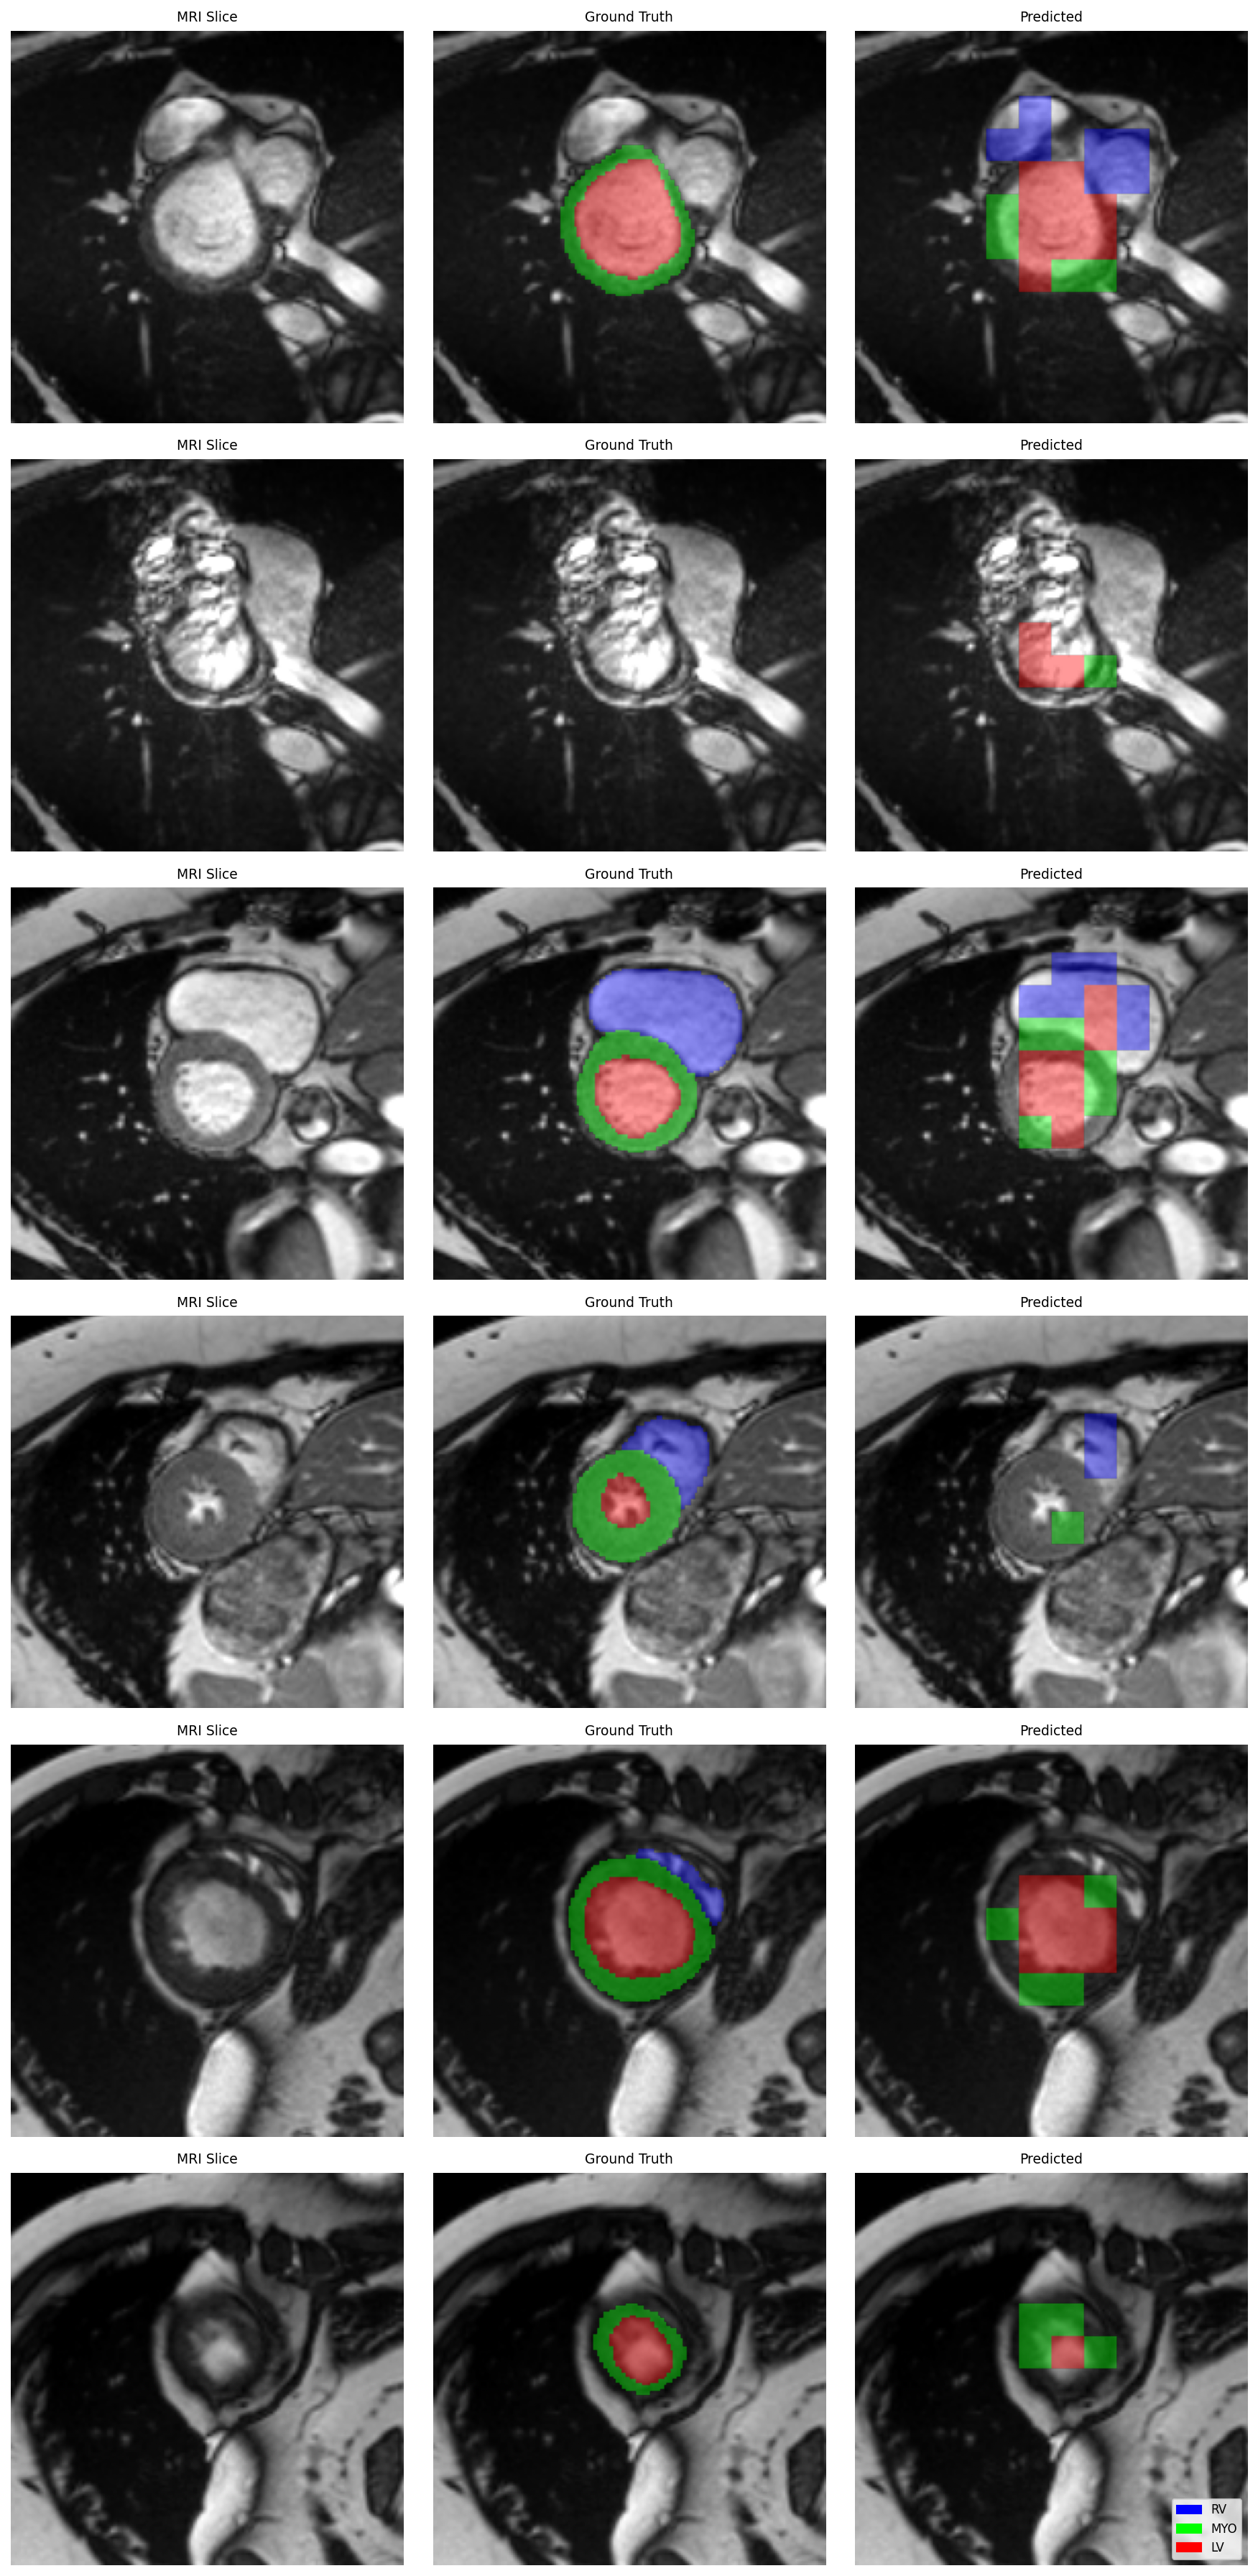

In [15]:
n_patches_per_slice = h_patches * w_patches  # 144
n_test_slices = len(test_slice_images)

# Show up to 6 sample slices
n_show = min(6, n_test_slices)
# pick evenly spaced slices
show_indices = np.linspace(0, n_test_slices - 1, n_show, dtype=int)

fig, axes = plt.subplots(n_show, 3, figsize=(12, 4 * n_show), dpi=150)
if n_show == 1:
    axes = axes[np.newaxis, :]

for row, slice_idx in enumerate(show_indices):
    img_np = test_slice_images[slice_idx]
    gt_np = test_slice_labels[slice_idx]

    # get predictions for this slice
    start = slice_idx * n_patches_per_slice
    end = start + n_patches_per_slice
    pred_patches = test_preds[start:end].reshape(h_patches, w_patches)

    # upsample predictions to image size for overlay
    pred_full = np.repeat(np.repeat(pred_patches, PATCH_SIZE, axis=0), PATCH_SIZE, axis=1)
    gt_overlay = overlay_labels(gt_np, IMAGE_SIZE, IMAGE_SIZE)
    pred_overlay = overlay_labels(pred_full, IMAGE_SIZE, IMAGE_SIZE)

    # plot
    axes[row, 0].imshow(img_np, cmap="gray")
    axes[row, 0].set_title("MRI Slice", fontsize=9)
    axes[row, 0].axis("off")

    axes[row, 1].imshow(img_np, cmap="gray")
    axes[row, 1].imshow(gt_overlay)
    axes[row, 1].set_title("Ground Truth", fontsize=9)
    axes[row, 1].axis("off")

    axes[row, 2].imshow(img_np, cmap="gray")
    axes[row, 2].imshow(pred_overlay)
    axes[row, 2].set_title("Predicted", fontsize=9)
    axes[row, 2].axis("off")

# add legend to last row
legend_patches = [
    mpatches.Patch(color=CLASS_COLORS[c][:3] + (1.0,), label=CLASS_NAMES[c])
    for c in range(1, NUM_CLASSES)
]
axes[-1, 2].legend(handles=legend_patches, loc="lower right", fontsize=8)

plt.tight_layout()
plt.show()

### Save Model + Metadata

In [ ]:
save_dir = "."
model_path = os.path.join(save_dir, "acdc_segmentation_model.pkl")

model_artifact = {
    "classifier": clf_final,
    "class_mapping": CLASS_NAMES,
    "optimal_C": best_c,
    "dinov3_model": MODEL_NAME,
    "image_size": (IMAGE_SIZE, IMAGE_SIZE),
    "patch_size": PATCH_SIZE,
    "train_patient_ids": pid_list_train,
    "test_patient_ids": pid_list_test,
    "test_macro_dice": macro_dice_test,
    "test_balanced_accuracy": bal_acc,
    "test_per_class_dice": class_dices_test,
}

with open(model_path, "wb") as f:
    pickle.dump(model_artifact, f)

print(f"Model and metadata saved to {model_path}")